## 
Created by Lucie J. Luecke 

creates a duplicate free dataframe based on the decisions made in *dup_decisions.ipynb* and plots summary figures of the removeed records and saves duplicate free version.

02/12/24: Modified the compositing process for metadata to fix bugs and make it more user friendly. Added some extra information to the bottom of the file (prior to the figures).

22/10/24: add the composite option for duplicates (create z-scores and average over shared time period)
30/9/24:  keep all original database values for removeed duplicates with more than one original database

# Set up environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import pickle
# import gzip
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from matplotlib.gridspec import GridSpec as GS
from copy import deepcopy as dc
import functions as f
import datetime
import f_duplicate_search as dupdet

In [3]:
# choose working directory
wdir = '/home/jupyter-lluecke/compile_proxy_database_v2.1'
os.chdir(wdir)
print(wdir)

/home/jupyter-lluecke/compile_proxy_database_v2.1


## Load dataset

In [4]:
# read dataframe 

db_name = 'dod2k_dupfree'

#db_name = 'dod2k'
#db_name = 'ch2k'
# db_name = 'fe23'
# db_name = 'iso2k'
# db_name = 'pages2k'
# db_name = 'sisal'


# load dataframe
df = f.load_compact_dataframe_from_csv(db_name)
# databasedir    = '%s/%s_compact.pkl'
# df = pd.read_pickle(databasedir)

print(df.info())
df.name = db_name

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4517 entries, 0 to 4516
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   DuplicateDetails                      4517 non-null   object 
 1   archiveType                           4517 non-null   object 
 2   climateInterpretation_variable        4517 non-null   object 
 3   climateInterpretation_variableDetail  4517 non-null   object 
 4   dataSetName                           4517 non-null   object 
 5   datasetId                             4517 non-null   object 
 6   geo_meanElev                          4434 non-null   float32
 7   geo_meanLat                           4517 non-null   float32
 8   geo_meanLon                           4517 non-null   float32
 9   geo_siteName                          4517 non-null   object 
 10  originalDataURL                       4517 non-null   object 
 11  originalDatabase 

In [5]:
# for ii in df.index:
#     if type(df.at[ii, 'paleoData_values'])==np.ma.core.MaskedArray: continue
#     dd=f.convert_to_nparray(df.at[ii, 'paleoData_values'])
#     df.at[ii, 'paleoData_values']=dd.data[~dd.mask]
#     df.at[ii, 'year']=df.at[ii, 'year'][~dd.mask]

In [6]:
df.set_index('datasetId', inplace = True)
df['datasetId']=df.index

# Apply duplicate decisions to dataframe

### Load duplicate decisions from csv

In [7]:
# Define here the initials and date of the decision file, or enter in next cell
initials = 'MNE'
date     = '24-12-05'

In [8]:
# print('LOAD THE DUPLICATE CANDIDATES FROM SAVED CSV FILE. PLEASE STATE THE FOLLOWING DETAILS:')
# initials = input('Operator initials: ') #'LL'
# date = input('Date (YY-MM-DD): ') #'LL'

In [9]:
# try:
filename      = '%s/dup_detection/dup_decisions_%s_%s_%s'%(df.name, df.name, initials, date)
data, header  = dupdet.read_csv(filename, header=True)
df_decisions  = pd.read_csv(filename+'.csv', header=5)

for hh in header:
    print(hh)
print(df_decisions.columns)
print(df.name)

 Decisions for duplicate candidate pairs. 
 Operated by Michael Neil Evans (MNE)
 E-Mail: mnevans@umd.edu
 Created on: 2024-12-05 21:06:19.972710 (UTC)
 repeat duplicate_detection on dupfree to check all duplicates found 2024/12/05 MNE
Index(['index 1', 'index 2', 'figure path', 'datasetId 1', 'datasetId 2',
       'originalDatabase 1', 'originalDatabase 2', 'geo_siteName 1',
       'geo_siteName 2', 'geo_meanLat 1', 'geo_meanLat 2', 'geo_meanLon 1',
       'geo_meanLon 2', 'geo_meanElevation 1', 'geo_meanElevation 2',
       'archiveType 1', 'archiveType 2', 'paleoData_proxy 1',
       'paleoData_proxy 2', 'originalDataURL 1', 'originalDataURL 2', 'year 1',
       'year 2', 'Decision 1', 'Decision 2', 'Decision type',
       'Decision comment'],
      dtype='object')
dod2k_dupfree


### Records to be REMOVED

In [10]:
# all candidate IDs
cand_IDs  = list(df_decisions['datasetId 1'])
cand_IDs += list(df_decisions['datasetId 2'])
cand_IDs  = np.unique(cand_IDs)

# load the records TO BE REMOVED
remove_IDs  = list(df_decisions['datasetId 1'][df_decisions['Decision 1']=='REMOVE'])
remove_IDs += list(df_decisions['datasetId 2'][df_decisions['Decision 2']=='REMOVE'])
remove_IDs  = np.unique(remove_IDs)
# print(remove_IDs)
# remove all records in remove_IDs from df_dupfree
remove_inds = np.unique([ii for ii in remove_IDs][:])
keep_inds   = np.unique([ii for ii in df.index if ii not in remove_IDs][:])

df_removed = df.loc[remove_inds]
df_dupfree = df.loc[keep_inds]

print(len(df_dupfree))
print(len(df_removed), remove_IDs)
print(df.name)

4516
1 ['FE23_asia_russ137w']
dod2k_dupfree


In [11]:
# add columns on decision process to df_dupfree:

dup_details = {id: '' for id in cand_IDs}

for ii in range(len(df_decisions)):
    id_1, id_2 = df_decisions.iloc[ii][['datasetId 1', 'datasetId 2']]
    db_1, db_2 = df_decisions.iloc[ii][['originalDatabase 1', 'originalDatabase 2']]
    dec_1, dec_2 = df_decisions.iloc[ii][['Decision 1', 'Decision 2']]

    if dec_1=='KEEP' and dec_2=='KEEP': continue # in this case no true duplicates!

    dec_dict = {'KEEP': 'KEPT in this dataset', 'REMOVE': 'REMOVED from this dataset', 'COMPOSITE': 'COMPOSITED to new record'}
    dup_details[id_1] += 'Duplicate record details: %s in %s (%s). '%(id_2, db_2, dec_dict[dec_2])
    dup_details[id_2] += 'Duplicate record details: %s in %s (%s). '%(id_1, db_1, dec_dict[dec_1])
    
    dup_details[id_1] += ' Decision type: %s '%df_decisions.iloc[ii]['Decision type']
    dup_details[id_2] += ' Decision type: %s '%df_decisions.iloc[ii]['Decision type']
    
    if df_decisions.iloc[ii]['Decision type']=='MANUAL': 
        operator_details = ' '.join(header[1:]).replace(' Modified ','')[:-2].replace(':','').replace('  E-Mail', '')
        dup_details[id_1]+=' (decision made %s).'%(operator_details)
        dup_details[id_2]+=' (decision made %s).'%(operator_details)
    
        dup_details[id_1]+=' Note on decision process: %s'%df_decisions.iloc[ii]['Decision comment']
        dup_details[id_2]+=' Note on decision process: %s'%df_decisions.iloc[ii]['Decision comment']

if 'DuplicateDetails' not in df_dupfree.columns:
    df_dupfree['DuplicateDetails']='N/A'

for ID in dup_details:
    if ID in df_dupfree.index: 
        if df_dupfree.at[ID, 'DuplicateDetails']=='N/A': df_dupfree.at[ID, 'DuplicateDetails']=dup_details[ID]
        else: df_dupfree.at[ID, 'DuplicateDetails']+=dup_details[ID]
# print(df_dupfree['DuplicateDetails'].unique())

### Records to be COMPOSITED

In [12]:
# load the records to be composited
comp_ID_pairs = df_decisions[(df_decisions['Decision 1']=='COMPOSITE')&(df_decisions['Decision 2']=='COMPOSITE')]#[(df_decisions['Decision 1']=='COMPOSITE')&(df_decisions['Decision 2']=='COMPOSITE')])
# print(comp_ID_pairs.info())

In [13]:
# create new composite data and metadata from the pairs

# loop through the composite pairs and check metadata
df_comp = dupdet.join_composites_metadata(df, comp_ID_pairs, df_decisions, header)


In [14]:
# remove all records which are in comp_IDs from df_dupfree
remove_comp_inds = np.unique([ii for ii in np.unique(comp_ID_pairs[['datasetId 1', 'datasetId 2']])])

warning          = [ii for ii in remove_comp_inds if ii not in df_dupfree.index]
remove_comp_inds = [ii for ii in remove_comp_inds if ii in df_dupfree.index]

# sample indices from df_dupfree which we want to keep
keep_inds   = np.unique([ii for ii in df_dupfree.index if ii not in remove_comp_inds])

# create dataframe which includes all removed records and dataframe which includes only duplicate free records
df_removed = pd.concat([df_removed, df_dupfree.loc[remove_comp_inds]])
df_dupfree = df_dupfree.loc[keep_inds]

# add composites to df_dupfree
df_dupfree = pd.concat([df_dupfree, df_comp], ignore_index = True, axis=0)
print(len(df_dupfree))
print(len(df_removed))

4516
1


In [15]:
# If records have appeared as composite AND have been removed, they will appear here as a warning:
if warning!=[]:
    print('WARNING! There were indices which have been removed initially, but then were composited later on.')
    print('This could lead to some remaining duplicates in the database.')
    print('Please go back and check that there are no residual duplicates or rerun the duplicate detection process on the duplicate free database.')
    print('The record(s) in question are:')
    for ii in warning:
        print(ii)

## Save duplicate free dataframe

In [16]:
df_dupfree = df_dupfree[sorted(df_dupfree.columns)[1:]+sorted(df_dupfree.columns)[:1]]


In [17]:
sorted(df_dupfree.columns)

['DuplicateDetails',
 'archiveType',
 'climateInterpretation_variable',
 'climateInterpretation_variableDetail',
 'dataSetName',
 'datasetId',
 'geo_meanElev',
 'geo_meanLat',
 'geo_meanLon',
 'geo_siteName',
 'originalDataURL',
 'originalDatabase',
 'paleoData_notes',
 'paleoData_proxy',
 'paleoData_sensorSpecies',
 'paleoData_units',
 'paleoData_values',
 'year',
 'yearUnits']

### save as pickle

In [18]:
df_dupfree.to_pickle('%s/%s_%s_%s_dup_free.pkl'%(df.name, df.name, initials, date))

print('Saved pickle file here: '+os.getcwd()+'/%s/%s_%s_%s_dup_free.pkl'%(df.name, df.name, initials, date))


Saved pickle file here: /home/jupyter-lluecke/compile_proxy_database_v2.1/dod2k_dupfree/dod2k_dupfree_MNE_24-12-05_dup_free.pkl


### save as csv

In [19]:
f.write_compact_dataframe_to_csv(df_dupfree, saveto=('/%s'%df.name, '%s_%s_%s'%(df.name, initials, date)+'_dup_free_%s'))


METADATA: archiveType, climateInterpretation_variable, climateInterpretation_variableDetail, dataSetName, datasetId, geo_meanElev, geo_meanLat, geo_meanLon, geo_siteName, originalDataURL, originalDatabase, paleoData_notes, paleoData_proxy, paleoData_sensorSpecies, paleoData_units, yearUnits, DuplicateDetails
Saved to /home/jupyter-lluecke/compile_proxy_database_v2.1/dod2k_dupfree/dod2k_dupfree_MNE_24-12-05_dup_free_%s.csv


In [20]:
# check that the csv loads
f.load_compact_dataframe_from_csv(df.name, 
                                  readfrom=('/%s/'%df.name,
                                            '%s_%s_%s'%(df.name, initials, date)+'_dup_free_%s')).info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4516 entries, 0 to 4515
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   DuplicateDetails                      4516 non-null   object 
 1   archiveType                           4516 non-null   object 
 2   climateInterpretation_variable        4516 non-null   object 
 3   climateInterpretation_variableDetail  4516 non-null   object 
 4   dataSetName                           4516 non-null   object 
 5   datasetId                             4516 non-null   object 
 6   geo_meanElev                          4433 non-null   float32
 7   geo_meanLat                           4516 non-null   float32
 8   geo_meanLon                           4516 non-null   float32
 9   geo_siteName                          4516 non-null   object 
 10  originalDataURL                       4516 non-null   object 
 11  originalDatabase 

In [21]:
# write header with operator information as README txt file
file = open('%s/%s_%s_%s'%(df.name, df.name, initials, date)+'_dup_free_README.txt', 'w')
for line in header:
    file.write(line+'\n')
file.close()

In [22]:

# choose today's date or manually put in the date of the duplicate detection processing
# date =  '24-11-26'
# date = str(datetime.datetime.utcnow())[2:10]
fn = f.find('%s_%s_%s_dup_free'%(df.name, initials, date), 
     '%s'%df.name)


In [23]:
if fn != []:
    print('----------------------------------------------------')
    print('Sucessfully finished the duplicate finalising process!'.upper())
    print('----------------------------------------------------')
    print('Saved the final output files in:')
    print()
    for ff in fn:
        print('   '+os.getcwd()+'/%s.'%ff)
    print()
    print('The duplicate detection process is now finished and the duplicate free database is ready to use!')
else:
    print('!!!!!!!!!!!!WARNING!!!!!!!!!!!')
    print('Final output file is missing.')
    print()
    print('Please re-run the notebook to complete duplicate finalising process.')

----------------------------------------------------
SUCESSFULLY FINISHED THE DUPLICATE FINALISING PROCESS!
----------------------------------------------------
Saved the final output files in:

   /home/jupyter-lluecke/compile_proxy_database_v2.1/dod2k_dupfree/dod2k_dupfree_MNE_24-12-05_dup_free.pkl.
   /home/jupyter-lluecke/compile_proxy_database_v2.1/dod2k_dupfree/dod2k_dupfree_MNE_24-12-05_dup_free_README.txt.
   /home/jupyter-lluecke/compile_proxy_database_v2.1/dod2k_dupfree/dod2k_dupfree_MNE_24-12-05_dup_free_metadata.csv.
   /home/jupyter-lluecke/compile_proxy_database_v2.1/dod2k_dupfree/dod2k_dupfree_MNE_24-12-05_dup_free_paleoData_values.csv.
   /home/jupyter-lluecke/compile_proxy_database_v2.1/dod2k_dupfree/dod2k_dupfree_MNE_24-12-05_dup_free_year.csv.

The duplicate detection process is now finished and the duplicate free database is ready to use!


In [24]:
fn

['dod2k_dupfree/dod2k_dupfree_MNE_24-12-05_dup_free.pkl',
 'dod2k_dupfree/dod2k_dupfree_MNE_24-12-05_dup_free_README.txt',
 'dod2k_dupfree/dod2k_dupfree_MNE_24-12-05_dup_free_metadata.csv',
 'dod2k_dupfree/dod2k_dupfree_MNE_24-12-05_dup_free_paleoData_values.csv',
 'dod2k_dupfree/dod2k_dupfree_MNE_24-12-05_dup_free_year.csv']

In [25]:
# for dod2k: write into own directory for subsequent running of the dup detection process.

print('Would you like to save this in an extra directory to be able to access the output for further data processing?')
print('In an extra directory, the output can be used to')
print('  - create figures using df_plot')
print('  - display/check output using df_check')
print('  - run another duplicate process (i.e. dup_detection -> dup_decisions -> dup_finalise) to check for residual duplicates')

write_in_dupfree_dir=''
while write_in_dupfree_dir.lower() not in ['y', 'yes', 'n', 'no']:
    write_in_dupfree_dir = input('Would you like to save this in an extra directory, i.e. create the directory: >>%s/%s_dupfree<<? [y/n]'%(os.getcwd(), df.name))
    if write_in_dupfree_dir.lower() in ['y', 'yes']:
        ddir = os.getcwd()+'/%s_dupfree'%df.name
        
        print('Create copies of the final output files.')
        print('The following files have been created:')
        
        fn = f.fns('%s_dupfree'%(df.name), other_cond='%s_dupfree'%df.name, end='.csv', print_dir=False)
        for ff in fn:
            if ('checkpoint' in ff): continue
            print('   '+os.getcwd()+'/%s'%ff)
        print('This directory may then serve as the starting point for any further duplicate detection.')
        print('Any information about further duplicates after running dup_detection, dup_decision or dup_finalise again on %s_dupfree will be found in this dirtectory.'%(df.name))
        print('---------------------------------------------------')
        print('In order to run another duplicate detection, please rerun the following notebooks:')
        print('1. dup_detection.ipynb')
        print('2. dup_decisions.ipynb')
        print('3. dup_finalise.ipynb')
        print('and use >>%s_dupfree<< as db_name'%df.name)
        print('---------------------------------------------------')
        
        df_dupfree.to_pickle('%s_dupfree/%s_dupfree_compact.pkl'%(df.name, df.name))
        f.write_compact_dataframe_to_csv(df_dupfree, saveto=('/%s_dupfree'%df.name, '%s_dupfree_compact'%(df.name)+'_%s'))
        # write header with operator information as README txt file
        file = open('%s_dupfree/%s_'%(df.name, df.name)+'compact_dupfree_README.txt', 'w')
        for line in header:
            file.write(line+'\n')
        file.close()

Would you like to save this in an extra directory to be able to access the output for further data processing?
In an extra directory, the output can be used to
  - create figures using df_plot
  - display/check output using df_check
  - run another duplicate process (i.e. dup_detection -> dup_decisions -> dup_finalise) to check for residual duplicates


Would you like to save this in an extra directory, i.e. create the directory: >>/home/jupyter-lluecke/compile_proxy_database_v2.1/dod2k_dupfree_dupfree<<? [y/n] y


Create copies of the final output files.
The following files have been created:
   /home/jupyter-lluecke/compile_proxy_database_v2.1/dod2k_dupfree_dupfree_compact_metadata.csv
   /home/jupyter-lluecke/compile_proxy_database_v2.1/dod2k_dupfree_dupfree_compact_paleoData_values.csv
   /home/jupyter-lluecke/compile_proxy_database_v2.1/dod2k_dupfree_dupfree_compact_year.csv
This directory may then serve as the starting point for any further duplicate detection.
Any information about further duplicates after running dup_detection, dup_decision or dup_finalise again on dod2k_dupfree_dupfree will be found in this dirtectory.
---------------------------------------------------
In order to run another duplicate detection, please rerun the following notebooks:
1. dup_detection.ipynb
2. dup_decisions.ipynb
3. dup_finalise.ipynb
and use >>dod2k_dupfree_dupfree<< as db_name
---------------------------------------------------
METADATA: archiveType, climateInterpretation_variable, climateInterpretatio

## Summary and summary plots of datasets

In [27]:
df_dupfree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4516 entries, 0 to 4515
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   archiveType                           4516 non-null   object 
 1   climateInterpretation_variable        4516 non-null   object 
 2   climateInterpretation_variableDetail  4516 non-null   object 
 3   dataSetName                           4516 non-null   object 
 4   datasetId                             4516 non-null   object 
 5   geo_meanElev                          4433 non-null   float32
 6   geo_meanLat                           4516 non-null   float32
 7   geo_meanLon                           4516 non-null   float32
 8   geo_siteName                          4516 non-null   object 
 9   originalDataURL                       4516 non-null   object 
 10  originalDatabase                      4516 non-null   object 
 11  paleoData_notes  

In [28]:
#%% print some info about the data
db_types = df_removed['originalDatabase'].unique()

col = f.get_colours(range(len(db_types)), 'tab10', 0, len(db_types))
#col = ['tab:blue','tab:green', 'tab:grey', 'tab:pink', 'tab:orange']
counts      = []
ticks       = []
colours     = []
for ii, db in enumerate(db_types):
    cc = df_removed['originalDatabase'][(df_removed['originalDatabase']==db)].count()
    counts  += [cc]
    ticks   += [db.split('(Ocn_103')[0]]
    colours += [col[ii]]

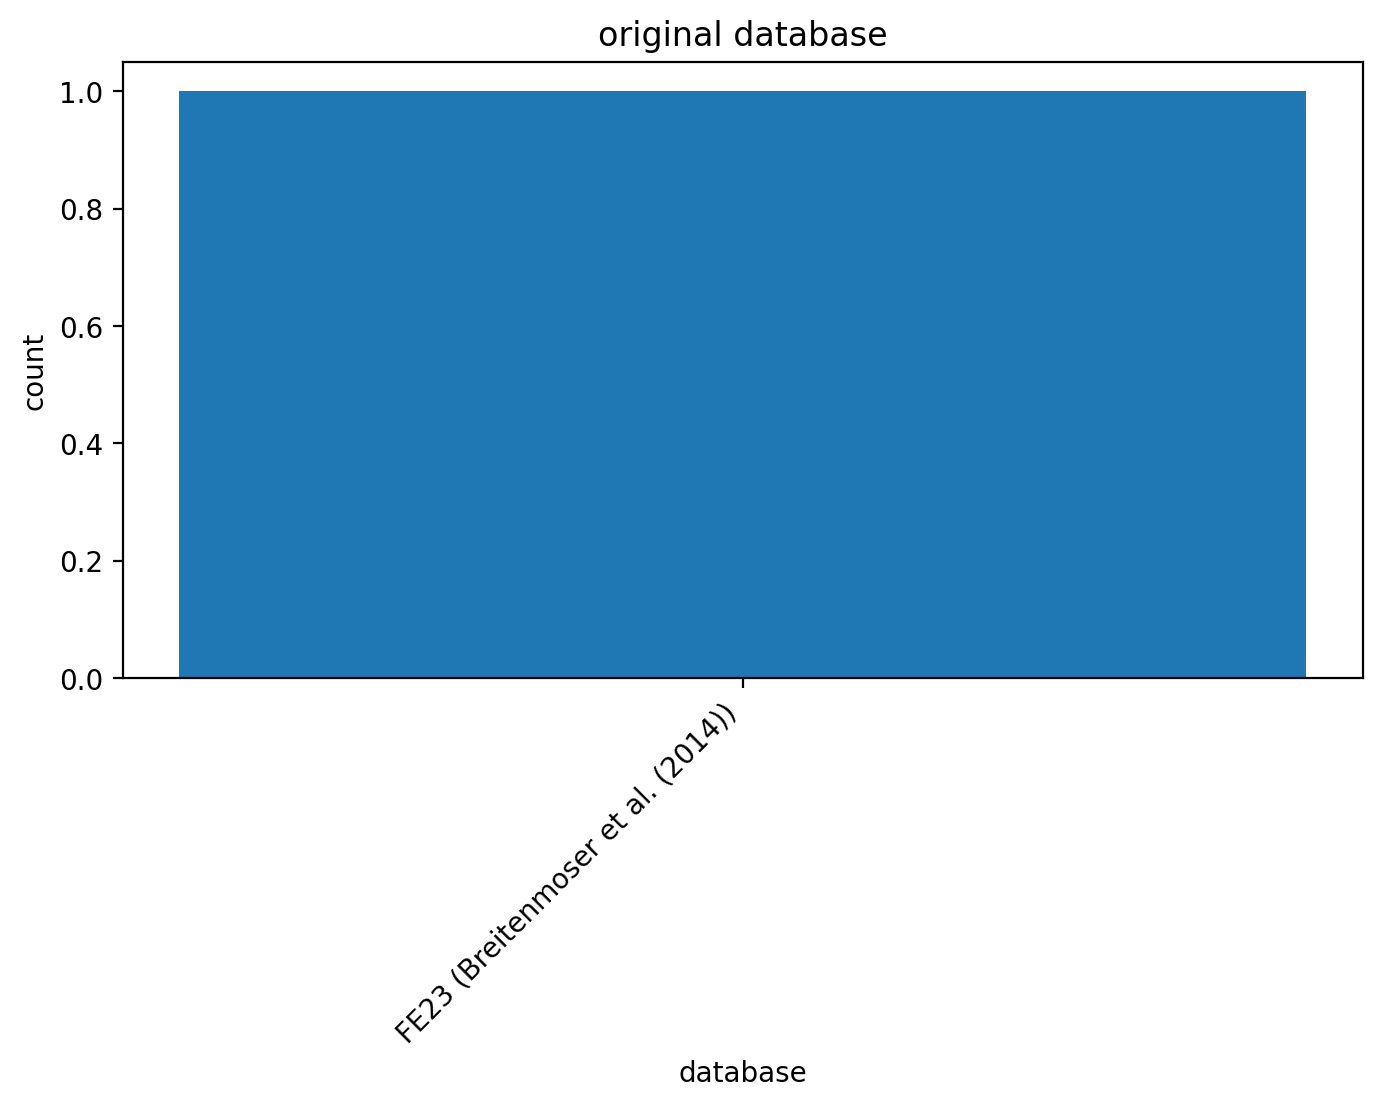

saved figure in /figs/dod2k_dupfree//SF_removed_recs_barchart_databases.pdf


In [29]:
# plot a bar chart of the number of proxy types included in the dataset
fig = plt.figure(figsize=(8,4), dpi=200)
ax  = plt.gca()
plt.bar(range(len(ticks)), counts, color=colours)
plt.xlabel('database')
plt.ylabel('count')
ax.set_xticks(range(len(ticks)), ticks, rotation=45, ha='right')
#ax.set_xticklabels(proxy_types, rotation=45, ha='right')
plt.title('original database')
plt.show()
fig.tight_layout()
f.figsave(fig, 'SF_removed_recs_barchart_databases', add='%s/'%df.name)

In [30]:
#%% print some info about the data
proxy_types   = df_removed['paleoData_proxy'].unique()
archive_types = df_removed['archiveType'].unique()
print(proxy_types)
print(archive_types)
col = f.get_colours(range(0,len(archive_types)), 'Accent', -1, len(archive_types))
counts      = []
ticks       = []
colours     = []
for ii, at in enumerate(archive_types):
    proxy_types   = df_removed['paleoData_proxy'][df_removed['archiveType']==at].unique()
    for pt in proxy_types:
        cc = df_removed['paleoData_proxy'][(df_removed['paleoData_proxy']==pt)&(df_removed['archiveType']==at)].count()
        # print('%25s'%pt+': '+str(cc))
        counts  += [cc]
        ticks   += [at+': '+pt]
        colours += [col[ii]]
        

['TRW']
['tree']


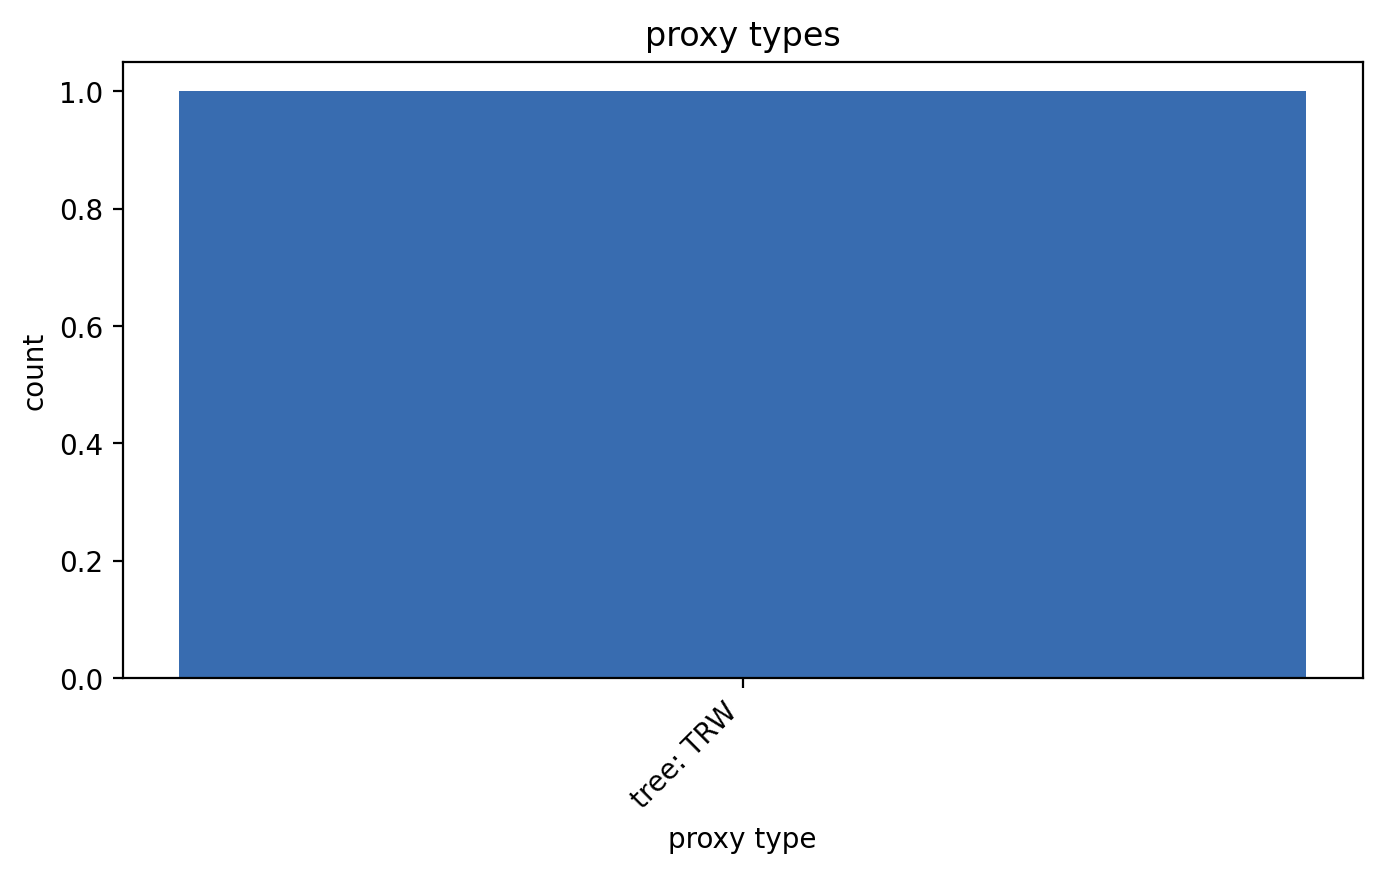

saved figure in /figs/dod2k_dupfree//SF_removed_recs_barchart_proxytypes.pdf


In [31]:
# plot a bar chart of the number of proxy types included in the dataset
fig = plt.figure(figsize=(8, 4), dpi=200)
ax  = plt.gca()
plt.bar(range(len(ticks)), counts, color=colours)

plt.xlabel('proxy type')
plt.ylabel('count')
ax.set_xticks(range(len(ticks)), ticks, rotation=45, ha='right')
#ax.set_xticklabels(proxy_types, rotation=45, ha='right')
plt.title('proxy types')
plt.show()
fig.tight_layout()
f.figsave(fig, 'SF_removed_recs_barchart_proxytypes', add='%s/'%df.name)


saved figure in /figs/dod2k_dupfree//SF_removed_spatial.pdf


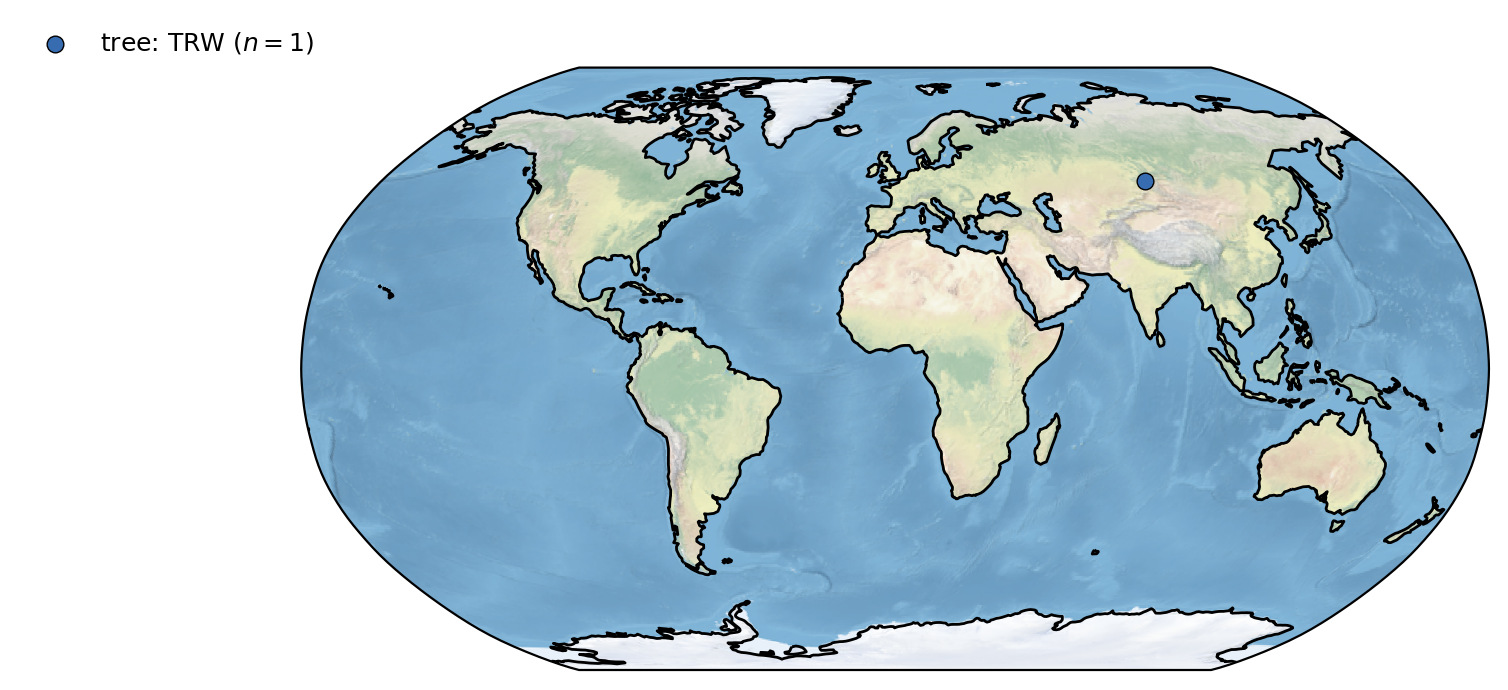

In [32]:
#%% plot the spatial distribution of the removeed records
proxy_lats = df_removed['geo_meanLat'].values
proxy_lons = df_removed['geo_meanLon'].values

# plots the map
fig = plt.figure(figsize=(10, 5), dpi=200)
grid = GS(1, 3)

ax = plt.subplot(grid[:, -2:], projection=ccrs.Robinson()) # create axis with Robinson projection of globe
ax.stock_img()
ax.add_feature(cfeature.LAND) # adds land features
ax.coastlines() # adds coastline features


mt = 'ov^<>pP*XDd'*10 # generates string of marker types
archive_marker = {aa: mm for aa, mm in zip(archive_types, mt)} # attributes marker type to each archive type
archive_colour = {aa: cc for aa, cc in zip(archive_types, col)}

# loop through the data to generate a scatter plot of each data record:
# 1st loop: go through archive types individually (determines marker type)
# 2nd loop: through paleo proxy types attributed to the specific archive, which is colour coded
for jj, at in enumerate(archive_types):
    arch_mask = df_removed['archiveType']==at
    arch_proxy_types = np.unique(df_removed['paleoData_proxy'][arch_mask])
    for ii, pt in enumerate(arch_proxy_types):
        pt_mask = df_removed['paleoData_proxy']==pt
        at_mask = df_removed['archiveType']==at
        plt.scatter(proxy_lons[pt_mask&at_mask], proxy_lats[pt_mask&at_mask], 
                    transform=ccrs.PlateCarree(), zorder=999,
                    marker=mt[ii], color=archive_colour[at], 
                    label=at+': '+pt+' ($n=%d$)'% df_removed['paleoData_proxy'][(df_removed['paleoData_proxy']==pt)&(df_removed['archiveType']==at)].count(), 
                    lw=.5, ec='k')

    
plt.legend(bbox_to_anchor=(0.03,1.1), ncol=2, fontsize=9, framealpha=0)
grid.tight_layout(fig)
f.figsave(fig, 'SF_removed_spatial', add='%s/'%df.name)
